# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Анализ активности пользователей: сравнение времени в приложении между Москвой и Санкт-Петербургом

- Автор: Булатова Юлия Ивановна 
- Дата: 23.04.2025

## Цели и задачи проекта

Цель проекта: проверить гипотезу о том, что пользователи из Санкт-Петербурга в среднем проводят больше времени в приложении (чтение и прослушивание книг), чем пользователи из Москвы, и определить, является ли это различие статистически значимым.

Задачи:
- Провести предварительный анализ данных
- Проверить гипотезу, изложенную в цели проекта, выбрав подходящий t-test
- Написать аналитическую записку по результатам теста 

## Описание данных

`https://code.s3.yandex.net/datasets/ab_test_participants.csv` — таблица участников тестов.
Структура файла:
- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.

`https://code.s3.yandex.net/datasets/ab_test_events.zip` — архив с одним csv-файлом, в котором собраны события 2020 года. 
Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python
3. Аналитическая записка

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
#Загружаем все необходимые для проекта библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загружаем датафрейм с данными пользователей
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
# Выведем данные датафрейма 
df.info()
# Выведем первые пять строк датафрейма
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


Датафрейм содержит 8784 строк и 4 столбца:
- `Unnamed: 0` - столбец типа `int64`, содержащий номер строки (дублирует индекс датафрейма). Удалим его, чтобы не занимать память компьютера. 
- `city` представлен типом данных `object` и содержит название города 
- `puid` содержит данные типа `int64` и хранит уникальный идентификатор пользователя 
- `hours` имеет тип `float64` и отображает общее количество часов активности  

В данных нет пропусков. 

In [4]:
#Удаляем столбец uunamed: 0 
df = df.drop('Unnamed: 0', axis = 1)
# Проверим датафрейм на дубликаты
print(f'Найдено {df.duplicated().sum()} явных дубликатов')
count_duplicated_puid = df.duplicated(subset = 'puid').sum()
print(f'Найдено {count_duplicated_puid} неявных дубликатов по идентификатору пользователя')

Найдено 0 явных дубликатов
Найдено 244 неявных дубликатов по идентификатору пользователя


In [5]:
# Выведем полученные дубликаты
df[df.duplicated(subset = 'puid', keep = False) == True].sort_values(by = 'puid', ascending = True)

,city,puid,hours
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506
...,...,...,...
6195,Москва,1130000020425037,0.310556
8775,Санкт-Петербург,1130000023864516,14.384722
6202,Москва,1130000023864516,142.830085
6210,Москва,1130000028554332,11.277554


Можно заметить, что идентификаторы пользователей действительно дублируются, причем один идентификатор принадлежит и Москве, и Санкт-Петербургу. Это может быть связано с техническими сбоями. Таких пользователей необходимо удалить, так как невозможно определить из какого города они  на самом деле. 

In [6]:
# Сохраняем изначальное количество строк датафрейма
lines = df.shape[0]

In [7]:
# Удаляем пользоваталей, попавших в обе группы
df = df.drop_duplicates(subset = 'puid', keep = False)

Для дальнейшей работы с данными необходимо рассмотреть распределение ключевого для нас столбца с количеством часов, проведенных в сервисе. Посмотрим на его описание, вызванное методом describe и построим гистограмму распределения для него и ящик с усами. 

In [8]:
df['hours'].describe()

count    8296.000000
mean       10.963892
std        37.753906
min         0.000022
25%         0.057493
50%         0.884214
75%         5.944675
max       978.764775
Name: hours, dtype: float64

Замечаем, что среднее время прослушивания составляет 10.96 часов при медиане 0.88 и стандартном отклонении 37.75. Это может указывать на высокий разброс данных и наличие аномально высоких значений. Минимальное значение столбца можно объяснить поведением нелояльных пользователей, которые попробовали сервис и покинули его.

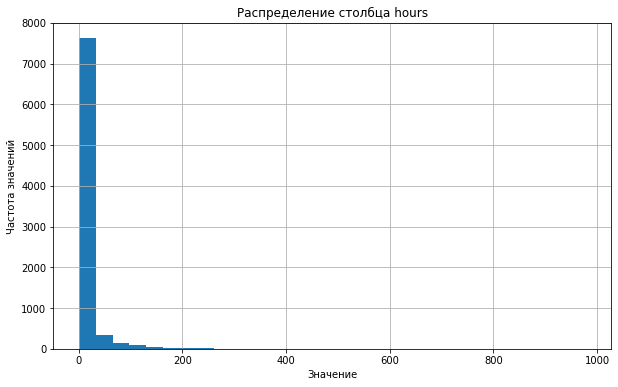

In [9]:
#Строим график 
plt.figure(figsize = (10,6))
plt.hist(df['hours'], bins = 30)
plt.title('Распределение столбца hours')
plt.ylabel('Частота значений')
plt.xlabel('Значение')
plt.grid()
plt.show()

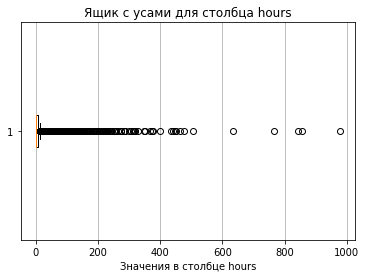

In [10]:
# Создаем горизонтальный ящик с усами
plt.boxplot(df['hours'], vert=False)  
plt.title('Ящик с усами для столбца hours')
plt.xlabel('Значения в столбце hours')
plt.grid(axis='x')
plt.show()

На обоих графиках заметен большой разброс данных и наличие очень высоких значений для длительности прослушивания. Чтобы избежать влияния таких показателей на анализ данных удалим значения, превышающие 99 процентиль - это позволит нам отфильтровать аномальные значения и не потерять большое количество информации. 

In [11]:
df = df[df['hours'] <= df['hours'].quantile(0.99)]

In [12]:
# Считаем число строк нового датафрейма
after_lines = df.shape[0]
print(f'Было удалено {lines - after_lines} строк, что составило {round(((lines - after_lines)*100/lines),2)}% от исходного датафрейма.')

Было удалено 571 строк, что составило 6.5% от исходного датафрейма.


В ходе предобработки датафрейма было обнаружено 488 пользователей, принадлежащих одновременно и к группе из Санкт-Петербруга, и к группе из Москвы. Было принято решение удалить данных пользователей, чтобы сохранить условие независимости двух групп. Помимо этого, мы удалили аномально высокие значения столбца с длительность прослушивания. Число удаленных строк составило 6.5% от исходного датафрейма. 

Теперь можно переходить к сравнению пользователей из двух городов и их статистик. Для начала рассчитаем, сколько всего пользователей в каждой группе и представим это на столбчатой диаграмме. 

In [13]:
# Группируем данные для построения графика
users_per_city = df.groupby('city').agg({'puid':'count', 'hours':'sum'}).reset_index()
print('Количество пользователей в Москве и Санкт-Петербурге')
print(users_per_city[['city', 'puid']])

Количество пользователей в Москве и Санкт-Петербурге
              city  puid
0           Москва  5929
1  Санкт-Петербург  2284


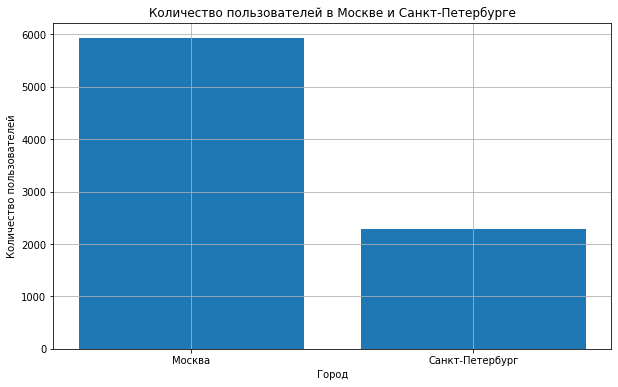

In [14]:
#Строим столбчатую диаграмму
plt.figure(figsize = (10,6))
plt.bar(users_per_city['city'], users_per_city['puid'])
plt.title('Количество пользователей в Москве и Санкт-Петербурге')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.grid()

Заметно, что пользователей из Москвы (5929) значительно больше, чем пользователей из Санкт-Петербурга (2284). Это не помешает нам проверить гипотезу, так как равенство групп не является необходимым для этого условием. Перейдем к сравнению статистик этих двух групп. 

In [15]:
#Выводим данные по Санкт-Петербургу 
print('Данные о столбце hours пользователей из Санкт-Петербурга')
print(df[df['city'] == 'Санкт-Петербург']['hours'].describe())
#Выводим данные по Москве
print('Данные о столбце hours пользователей из Москвы')
print(df[df['city'] == 'Москва']['hours'].describe())

Данные о столбце hours пользователей из Санкт-Петербурга
count    2284.000000
mean        8.377901
std        19.723539
min         0.000025
25%         0.057032
50%         0.852310
75%         5.672186
max       152.338086
Name: hours, dtype: float64
Данные о столбце hours пользователей из Москвы
count    5929.000000
mean        8.064964
std        19.733973
min         0.000022
25%         0.055492
50%         0.856322
75%         5.639621
max       153.639891
Name: hours, dtype: float64


Заметим, что все показатели столбца `hours` у пользователей из двух гороов примерно одинаковы - и стандартное отклонение, и макимальная, и минимальная длительность прослушивания. Средняя продолжительность прослушивания в Санкт-Петербурге составила 8.38 часов, а в Москве - 8.06. Проверим, является ли это различие статистически значимым. 

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Для проверки гипотезы будем использовать t-test Уэлча, так как он более устойчив к выбросам данных, не требует равенства выборочных дисперсий. Кроме того, размеры групп сильно отличаются, поэтому такой тест будет оптимальным вариантом. 

In [16]:
spb_group = df[df['city'] == 'Санкт-Петербург']['hours']
msk_group = df[df['city'] == 'Москва']['hours']
# пишем код для t-test 
alpha = 0.05
stat_welch_ttest, p_value_welch_ttest = ttest_ind(spb_group,
                                                  msk_group,
                                                  equal_var = False,
                                                 alternative = 'greater')
 
if p_value_welch_ttest < alpha: 
    print(f'p-value теста Уэлча={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза отвергается.')
    print('Интерпретация: средняя активность пользователей в Санкт-Петербурге больше.')
else:
    print(f'p-value теста Уэлча={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение.')
    print('Интерпретация: средняя активность пользователей в часах в Москве и Санкт-Петербурге не различается.')

p-value теста Уэлча=0.26
Нулевая гипотеза находит подтверждение.
Интерпретация: средняя активность пользователей в часах в Москве и Санкт-Петербурге не различается.


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



Была проведена проверка гипотезы о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Для ее проверки был выбран t-test Уэлча, который обладает низкой чувствительность к неравным дисперсиям и применение которого возможно при разнице в размере групп. Уровень значимости `alpha` был выбран равным 0.05. 

Результат теста показал p-value = 0.26, что больше выбранного уровня значимости. А значит, гипотеза о том, что среднее время активности пользователей в Санкт-Петербурге больше, не подтвердилась. 

Причиной такого результата может быть одинаковый уровень лояльности к сервису пользователей Москвы и Санкт-Петербурга. Региональная принадлежность не влияет на вовлеченность пользователей. Также причиной могут быть схожие бытовые привычки и образ жителей этих городов.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Цель исследования: оценить эффективность новой версии интерфейса онлайн-магазина BitMotion Kit в сравнении со старой, чтобы определить, приводит ли изменение дизайна к увеличению конверсии в покупки.


Задачи:
- Проверить корректность проведения A/B-теста
- Определить статистическую значимость различий
- Сформулировать вывод

Гипотезы, проверяемые в исследовании:

Нулевая гипотеза $H_0: конверсия в группе B не больше, чем в группе A.

Альтернативная гипотеза $H_1: конверсия в группе B превышает конверсию в группе A.

## 2. Загрузите данные, оцените их целостность.


In [17]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [18]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [19]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Полученный датафрейм `participants` содержит 14525 строк и 4 столбца:
- `user_id` – уникальный идентификатор пользователя (должен быть без дубликатов)
- `group` – группа A/B-теста (A – контроль, B – тестовая)
- `ab_test` - название теста, в котором участвовал пользователей
- `device` – тип устройства

Данные не содержат пропусков и соответсвуют заявленному описанию.

In [20]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [21]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Датафрейм `events` содержит информацию о действиях пользователей, представленную в 787286 строках и 4 столбцах:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Этот столбец содержит пропуски, однако нам не понадобится этот столбец для работы, поэтому пропуски некритичны. 


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [22]:
# Выделяем пользователей, которые участвовали в нескольких тестах, а также тех, которые могли попасть в две группы 
#одновременно, для последующего удаления
duplicated_participants = participants[participants['user_id'].duplicated(keep=False)].reset_index()
duplicated_participants.head()

,index,user_id,group,ab_test,device
0,1,001064FEAAB631A1,B,recommender_system_test,Android
1,2,001064FEAAB631A1,A,interface_eu_test,Android
2,9,00341D8401F0F665,A,recommender_system_test,iPhone
3,10,00341D8401F0F665,B,interface_eu_test,iPhone
4,25,0082295A41A867B5,A,interface_eu_test,iPhone


Заметим, что есть пользователи, которые участвовали в двух и более тестах одновременно. Их необходимо удалить, так как не предсталяется возможным определить, какие изменения в системе влияли на их действия. 

In [23]:
# Удаляем этих пользователей из исходного датафрейма
participants = participants[~(participants['user_id'].isin(duplicated_participants['user_id']))]

In [24]:
# Выделим пользователей, участвовавших в проведении теста 
test_participants = participants[participants['ab_test'] == 'interface_eu_test']
test_participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
7,0031F1B5E9FBF708,A,interface_eu_test,Android


Перейдем к проверке групп на независимость - отсутствие пользователей, одновременно оказавшихся в друг группах. 

In [25]:
# Находим уникальных пользователей в обеих группах
group_a = test_participants[test_participants['group'] == 'A']['user_id'].unique()
group_b = test_participants[test_participants['group'] == 'B']['user_id'].unique()
#Находим пересечение этих групп
intersection = list(set(group_a) & set(group_b))
if len(intersection) == 0: 
    display('Пересечений пользователей нет. Выборки независимы')
else:
    display(f'Пользователи {intersection} находятся в обеих выборках')

'Пересечений пользователей нет. Выборки независимы'

Проверим насколько равномерно распределены пользователи по группам. Для этого сгруппируем данные и визуализируем их.

In [26]:
# Группируем данные по группам
test_participants_grouped = test_participants.groupby('group').agg({'user_id':'nunique'}).reset_index()
print('Число пользователей в группах теста')
print(test_participants_grouped)

#Считаем процентную разницу между двумя группами
percent_difference = 100 * abs(test_participants_grouped['user_id'][0] - test_participants_grouped['user_id'][1]) / test_participants_grouped['user_id'][0]
print(f'Процентная разница в количестве пользователей в группах A и B {round(percent_difference,2)}%')

Число пользователей в группах теста
  group  user_id
0     A     4952
1     B     5011
Процентная разница в количестве пользователей в группах A и B 1.19%


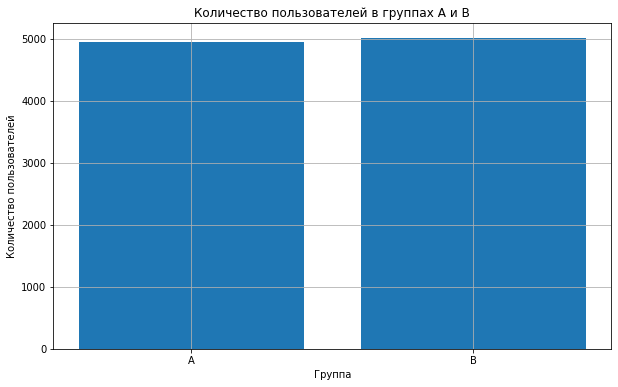

In [27]:
#Для наглядности строим столбчатый график
plt.figure(figsize = (10,6))
plt.bar(test_participants_grouped['group'], test_participants_grouped['user_id'])
plt.title('Количество пользователей в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.grid()

Количество пользователей в группах A и B составило 4952 и 5011 соответственно. Разница между ними незначительна и равна 1.19%, что допускается при проведении A-B тестирования. 

Убедимся в том, что пользователи равномерно распределены по категориальным переменным — типам устройства в рамках своей группы и в целом. 

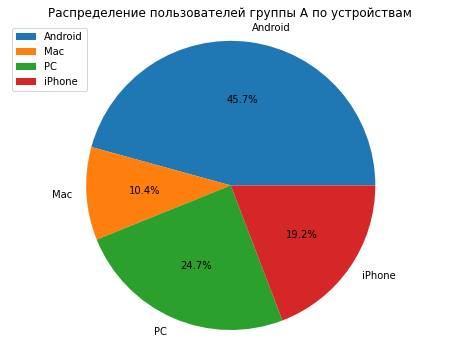

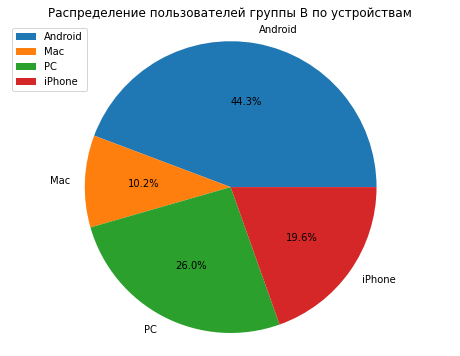

In [28]:
#Агрегируем данные для построения графиков по распределению пользователей вннутри каждой группы
devices = test_participants.groupby(['group','device']).agg({'user_id':'nunique'}).reset_index()
#Строим график для пользователей группы A
plt.figure(figsize=(8, 6))
plt.pie(devices[devices['group'] == 'A']['user_id'], labels = devices[devices['group'] == 'A']['device'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Распределение пользователей группы A по устройствам')
plt.legend()
plt.show()

#Строим график для пользователей группы B
plt.figure(figsize=(8, 6))
plt.pie(devices[devices['group'] == 'B']['user_id'], labels = devices[devices['group'] == 'B']['device'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Распределение пользователей группы B по устройствам')
plt.legend()
plt.show()

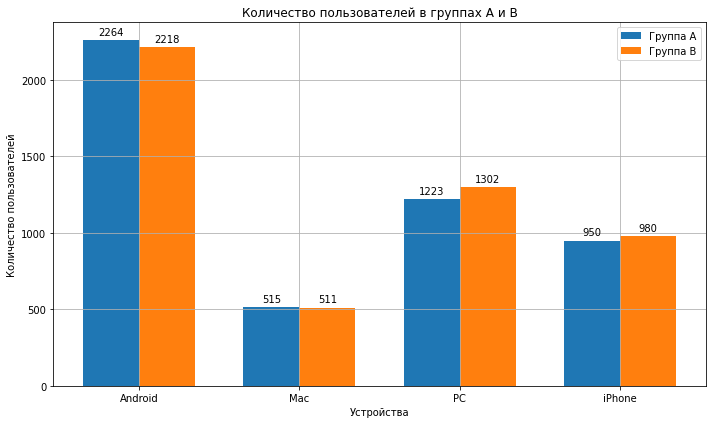

In [29]:
# Строим столбчатую диаграмму, отображающую сравнение распределения пользователей из групп по устройствам
labels = devices['device'].unique()
group_A_means = devices[devices['group'] == 'A']['user_id'].values
group_B_means = devices[devices['group'] == 'B']['user_id'].values

# Параметры для построения столбцов
x = np.arange(len(labels))  # позиции по оси X
width = 0.35  # ширина столбцов

# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 6))
bars_A = ax.bar(x - width/2, group_A_means, width, label='Группа A')
bars_B = ax.bar(x + width/2, group_B_means, width, label='Группа B')

# Добавление подписей и заголовка
ax.set_title('Количество пользователей в группах A и B')
ax.set_xlabel('Устройства')
ax.set_ylabel('Количество пользователей')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Отображение значений над столбцами
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bars_A)
autolabel(bars_B)
# Показать график
plt.grid()
plt.tight_layout()
plt.show()

По графикам видно, что пользователи распределены равномерно по устройствам как внутри своих групп, так и в сравнении с другой группой. Это значит, что данные по пользователям сопоставимы и их возможно использовать в дальнейшем. 

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [30]:
#Создаем отдельный датафрейм с действиями только тех пользователей, которые участвуют в тестировании
test_events = events[events['user_id'].isin(test_participants['user_id'])]
test_events = test_events.merge(test_participants, how = 'left', on = 'user_id')
test_events = test_events.drop(['ab_test', 'device'], axis = 1)
test_events

,user_id,event_dt,event_name,details,group
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B
...,...,...,...,...,...
73810,F80C9BDDEA02E53C,2020-12-30 10:02:43,purchase,4.49,B
73811,F80C9BDDEA02E53C,2020-12-30 10:03:51,purchase,4.49,B
73812,F80C9BDDEA02E53C,2020-12-30 10:03:52,product_cart,NaN,B
73813,6181F3835EBE66BF,2020-12-30 12:10:39,product_cart,NaN,B


In [31]:
test_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73815 entries, 0 to 73814
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     73815 non-null  object        
 1   event_dt    73815 non-null  datetime64[ns]
 2   event_name  73815 non-null  object        
 3   details     19450 non-null  object        
 4   group       73815 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.4+ MB


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [32]:
#Приведем столбец с датой к формату даты
test_events = test_events.copy()
test_events['event_dt'] = pd.to_datetime(test_events['event_dt']).dt.date

In [33]:
# Выделим дату регистрации каждого пользователя 
registration_dt = test_events[test_events['event_name'] == 'registration'] [['user_id', 'event_dt']].reset_index()
registration_dt = registration_dt.rename(columns = {'event_dt':'registration_dt'})
registration_dt['registration_dt'] = pd.to_datetime(registration_dt['registration_dt']).dt.date
registration_dt = registration_dt.drop('index', axis = 1)
registration_dt

,user_id,registration_dt
0,5F506CEBEDC05D30,2020-12-06
1,51278A006E918D97,2020-12-06
2,A0C1E8EFAD874D8B,2020-12-06
3,275A8D6254ACF530,2020-12-06
4,0B704EB2DC7FCA4B,2020-12-06
...,...,...
9958,52B5A81EFC31AF1D,2020-12-23
9959,B1D88FBD4BA58E1B,2020-12-23
9960,38CA3A3C4FE3FEFD,2020-12-23
9961,16CCB1C8C4DCF1AF,2020-12-23


In [34]:
# Добавим столбец с датой регистрации каждого пользователя в датафрейм test_events
test_events = test_events.merge(registration_dt, how = 'left', on = 'user_id')

In [35]:
# Добавим столбец с расчетом количества дней с даты регистрации пользователя
test_events['days_since_registration'] = test_events['event_dt'] - test_events['registration_dt']
test_events['days_since_registration'] = test_events['days_since_registration'].dt.days
# Оставляем только те события, которые были совершены в течение первых семи дней после регистрации
test_events = test_events[test_events['days_since_registration'] <= 7]
test_events

,user_id,event_dt,event_name,details,group,registration_dt,days_since_registration
0,5F506CEBEDC05D30,2020-12-06,registration,0.0,A,2020-12-06,0
1,51278A006E918D97,2020-12-06,registration,-3.8,A,2020-12-06,0
2,A0C1E8EFAD874D8B,2020-12-06,registration,-3.32,B,2020-12-06,0
3,275A8D6254ACF530,2020-12-06,registration,-0.48,A,2020-12-06,0
4,0B704EB2DC7FCA4B,2020-12-06,registration,0.0,B,2020-12-06,0
...,...,...,...,...,...,...,...
73791,D4E530F6595A05A3,2020-12-29,product_cart,NaN,B,2020-12-22,7
73793,31DBDCA380DD035F,2020-12-29,product_page,NaN,B,2020-12-23,6
73797,E6D34EE376AADC42,2020-12-29,product_cart,NaN,A,2020-12-22,7
73798,E6D34EE376AADC42,2020-12-29,product_cart,NaN,A,2020-12-22,7


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [36]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  
beta = 0.2  
power = 0.8  
mde = 0.1  # в относительном выражении прирост 3 процентных пунктов к 30% составляет 10%

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 1569


В ходе A/B - тестирования были собраны выборки с достаточным количеством пользователей, чтобы провести анализ влияния изменений сайта на конверсию. 

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [37]:
all_users = test_events.groupby('group').agg({'user_id':'nunique'})
purchase_users = test_events[test_events['event_name'] == 'purchase'].groupby('group').agg({'user_id':'nunique'})
table = all_users.merge(purchase_users, on = 'group').reset_index()
table = table.rename(columns = {'user_id_x':'total_users', 'user_id_y': 'purchased_users'})
table['part_of_purchased'] = round(table['purchased_users'] / table['total_users'],2)
table 

,group,total_users,purchased_users,part_of_purchased
0,A,4952,1411,0.28
1,B,5011,1519,0.30


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

По результатам тестирования, доля пользователей, совершивших покупку в тестовой группе (B) больше, чем в контрольной. Можно предположить, что упрощение интерфейса сайта положительно сказалось на конверсию пользователя в покупателя. Однако прирост составил только 2 процентных пунка вместо планируемых 3. Эффект от изменений есть - стоит узнать, насколько статистически значимы полученные результаты. 

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Проверяемые гипотезы: 


Нулевая гипотеза $H_0: конверсия в группе B не больше, чем в группе A.

Альтернативная гипотеза $H_1: конверсия в группе B превышает конверсию в группе A.

In [38]:
# Для определения статистической значимости изменения конверсии используем z-тест
# Для начала проверим выполнение предпосылки о достаточном количестве данных 
# Количество зарегистрировавшихся пользователей
n_a = table['total_users'][0]
n_b = table['total_users'][1]
# Количество успешных сессий
m_a = table['purchased_users'][0]
m_b = table['purchased_users'][1]
# Доля успехов для каждой группы
p_a, p_b = m_a/n_a, m_b/n_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных не выполняется!')
    
# Устанавливаем уровень значимости     
alpha = 0.05
#Проводим тест
print('Нулевая гипотеза: упрощение интерфейса не сделало конверсию в группе В выше, чем в группе А')
print('Альтернативная гипотеза: упрощение интерфейса сайта повысило конверсию в группе В по сравнению с группой А')
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative= 'smaller'
)
print(f'pvalue={round(p_value_ztest,2)}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение! Упрощение интерфейса сайта не повлияло на долю успешных сессий')
else:
    print('Нулевая гипотеза не находит подтверждения! Упрощение интерфейса сайта увеличило долю успешных сессий')
    

Предпосылка о достаточном количестве данных выполняется!
Нулевая гипотеза: упрощение интерфейса не сделало конверсию в группе В выше, чем в группе А
Альтернативная гипотеза: упрощение интерфейса сайта повысило конверсию в группе В по сравнению с группой А
pvalue=0.02
Нулевая гипотеза не находит подтверждения! Упрощение интерфейса сайта увеличило долю успешных сессий


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

A/B-тестирование показало статистически значимый результат p-value = 0.02 (< 0.05), позволяеющий отвергнуть нулевую гипотезу и принять альтернативную. А значит, урощение интерфейса действительно положительно повлияло на конверсию в группе B - упрощенный интерфейс увеличил долю успешных сессий (покупок) по сравнению со старой версией не на планируемые 3 процентных пункта, но на 2,  что недостаточно много, но тем не менее является ститистически значимым. Мы рекомендуем внедрить новую версию интерфейса для всех пользователей, так как она доказала свою эффективность.